In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import scipy.stats
import astropy.coordinates as coord
import astropy.constants as consts
import cosmolopy.distance as cd
import pathos.multiprocessing

from astropy.io import fits

cosmo = {u'h': 0.688, u'omega_lambda_0': 0.705, u'omega_k_0': 0.0, u'omega_M_0': 0.295}
cd.set_omega_k_0(cosmo)

{u'h': 0.688, u'omega_M_0': 0.295, u'omega_k_0': 0.0, u'omega_lambda_0': 0.705}

In [2]:
# Read galaxies from a survey
survey = fits.open('../BAM/Old/nsa_v1.fits')[1].data
mass = survey['SERSIC_MASS']
RA = survey['RA']
DEC = survey['DEC']
dist = survey['ZDIST']*consts.c.to_value('km/s')/(cosmo['h']*100)

#Get rid of NaNs
rem_ids = np.where(np.isnan(mass)==True)

mass = np.delete(mass, rem_ids)
RA = np.delete(RA, rem_ids)
DEC = np.delete(DEC, rem_ids)
dist = np.delete(dist, rem_ids)

#Get rid of instances where mass<0
rem_ids = np.where(mass<=0)

mass = np.delete(mass, rem_ids)
RA = np.delete(RA, rem_ids)
DEC = np.delete(DEC, rem_ids)
dist = np.delete(dist, rem_ids)

#Calculate log10 mass
log_mass = np.log10(mass)

# Remove instances where mass < threshold. Stop using mass array here

rem_ids = np.where(log_mass<=9.8)

log_mass = np.delete(log_mass, rem_ids)
RA = np.delete(RA, rem_ids)
DEC = np.delete(DEC, rem_ids)
dist = np.delete(dist, rem_ids)

# Make some cuts on RA
ids = np.where(np.logical_and(100<RA, RA<300))
RA = RA[ids]
DEC = DEC[ids]
dist = dist[ids]
log_mass = log_mass[ids]

#Make some cuts on dist
ids = np.where(dist>0.001)
RA = np.array(RA[ids], dtype='float64')
DEC = np.array(DEC[ids], dtype='float64')
dist = dist[ids]
log_mass = log_mass[ids]

N = log_mass.size

cut_survey = np.zeros(N, dtype={'names':('ra', 'dec', 'dist'),
                          'formats':('float64', 'float64', 'float64')})
cut_survey['ra'] = np.ravel(RA)
cut_survey['dec'] = np.ravel(DEC)
cut_survey['dist'] = np.ravel(dist)


np.save('../Data/sdss_cutoff.npy', cut_survey)



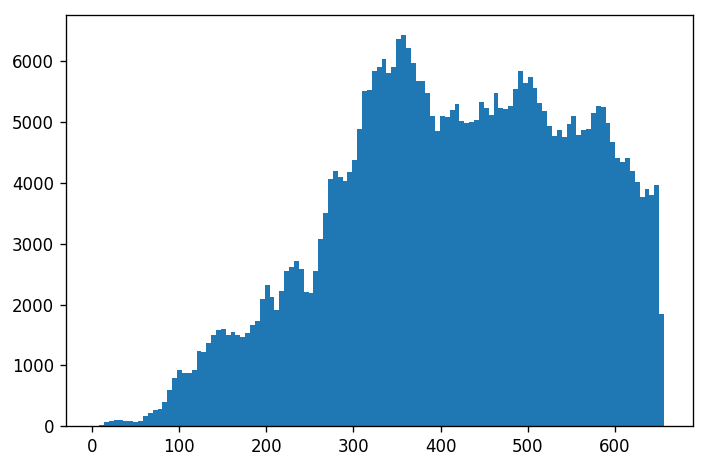

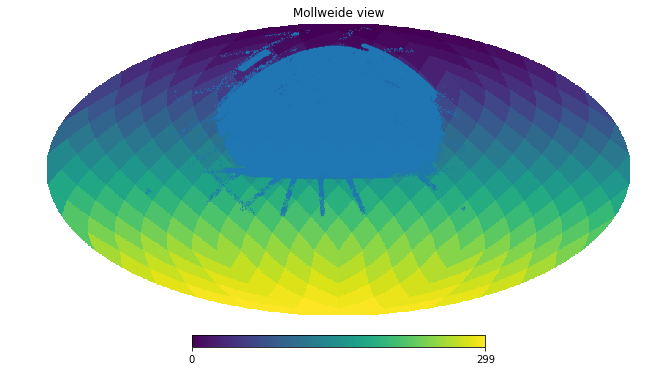

In [3]:
# Make a histogram just to check everything is going according to plan..
plt.figure(dpi=120)
plt.hist(dist, bins='auto')
plt.tight_layout()
plt.show()

# And a HealPy map to plot galaxies pos..
nside=5
hp.mollview(np.arange(hp.nside2npix(nside)), rot=[180, 0, 0])
hp.projscatter(np.pi/2-np.deg2rad(DEC), np.deg2rad(RA), s=0.05)
plt.show()

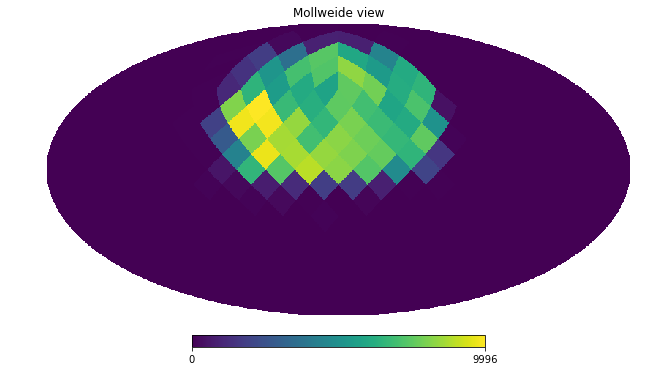

In [4]:
# Calculate pixels in which there are at least cutoff number of galaxies
N = RA
pix_count = np.zeros(hp.nside2npix(nside))

for r, d in zip(np.deg2rad(RA), np.deg2rad(DEC)):
    pix = hp.ang2pix(nside, np.pi/2-d, r)
    pix_count[pix] += 1

hp.mollview(pix_count, rot=[180, 0, 0])

#Get a list of pixels in which there are galaxies
active_pixels = list()
for i in range(len(pix_count)):
    if pix_count[i] > 1000:
        active_pixels.append(i)

In [9]:
%%capture
# Start generating random catalog
boxsize=700
N_pools = 8
min_dist = np.min(dist)
max_dist = np.max(dist)

pool = pathos.multiprocessing.ProcessingPool(N_pools)

def get_galaxy(i):
    while True:
        x, y, z = scipy.stats.uniform.rvs(loc=-1, scale=2, size=3)*boxsize
        pix = hp.vec2pix(nside, x,y,z)

        if pix in active_pixels:
            sim_dist = np.sqrt(x**2+y**2+z**2)
            if min_dist < sim_dist < max_dist:
                theta, phi = hp.vec2ang(np.array([x,y,z]))
                return [np.pi/2-theta, phi, sim_dist]

Nmax = 4500000
loop_out = pool.map(get_galaxy, range(Nmax))
rand_DEC = np.array([float(item[0]) for item in loop_out])
rand_RA = np.array([float(item[1]) for item in loop_out])
rand_Dist = np.array([float(item[2]) for item in loop_out])


pool.close()
pool.join()
pool.clear()
    

catalog = np.zeros(Nmax, dtype={'names':('ra', 'dec', 'dist'),
                          'formats':('float64', 'float64', 'float64')})
catalog['ra'] = np.ravel(rand_RA)
catalog['dec'] = np.ravel(rand_DEC)
catalog['dist'] = np.ravel(rand_Dist)


np.save('../Data/randCat_matchnsa.npy', catalog)

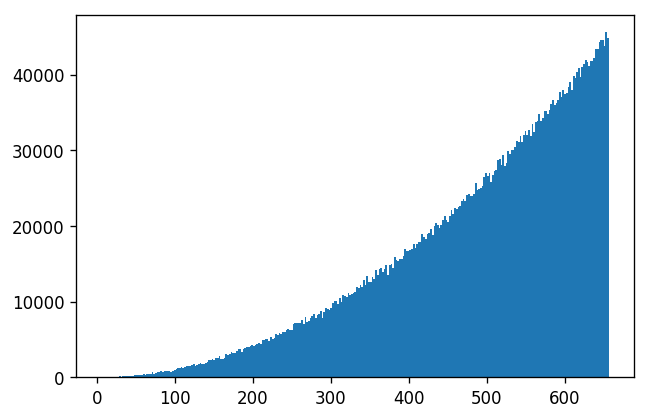

In [10]:
plt.figure(dpi=120)
plt.hist(rand_Dist, bins='auto')
plt.show()

# hp.mollview(np.zeros(12), rot=[180, 0, 0])
# hp.projscatter(np.pi/2-rand_DEC, rand_RA)